In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/brain_tumour

Mounted at /content/drive/
/content/drive/MyDrive/Projects/brain_tumour


In [ ]:
!unzip /content/drive/MyDrive/Projects/brain_tumour/Task01_BrainTumour.zip -d /content

Archive:  /content/drive/MyDrive/Projects/brain_tumour/Task01_BrainTumour.zip
   creating: /content/Task01_BrainTumour/
  inflating: /content/__MACOSX/._Task01_BrainTumour  
  inflating: /content/Task01_BrainTumour/.DS_Store  
  inflating: /content/__MACOSX/Task01_BrainTumour/._.DS_Store  
   creating: /content/Task01_BrainTumour/labelsTr/
  inflating: /content/__MACOSX/Task01_BrainTumour/._labelsTr  
   creating: /content/Task01_BrainTumour/imagesTr/
  inflating: /content/__MACOSX/Task01_BrainTumour/._imagesTr  
   creating: /content/Task01_BrainTumour/imagesTs/
  inflating: /content/__MACOSX/Task01_BrainTumour/._imagesTs  
  inflating: /content/Task01_BrainTumour/dataset.json  
  inflating: /content/__MACOSX/Task01_BrainTumour/._dataset.json  
  inflating: /content/Task01_BrainTumour/labelsTr/BRATS_457.nii.gz  
  inflating: /content/__MACOSX/Task01_BrainTumour/labelsTr/._BRATS_457.nii.gz  
  inflating: /content/Task01_BrainTumour/labelsTr/BRATS_306.nii.gz  
  inflating: /content/__MA

In [ ]:
import os
import nibabel as nib
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from pathlib import Path
from tqdm import tqdm
import torch

In [ ]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

In [ ]:
def normalize_image(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

In [ ]:
def resize_image(image, new_shape=(128, 128)):
    resized_image = resize(image, new_shape, anti_aliasing=True)
    return resized_image

In [ ]:
images_path = Path("/content/Task01_BrainTumour/imagesTr")
labels_path = Path("/content/Task01_BrainTumour/labelsTr")

In [ ]:
def change_image_path_to_label(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [ ]:
all_files = list(images_path.glob("BRATS_*"))  # Get all subjects
len(all_files)

484

In [ ]:
img = load_nifti_image(all_files[0])
img.shape

(240, 240, 155, 4)

In [ ]:
!rm -rf /content/brain_tumour

In [ ]:
save_root = Path("/content/brain_tumour")

for counter, mri_data_path in enumerate(tqdm(all_files)):
  path_to_label = change_image_path_to_label(mri_data_path)

  image_data = load_nifti_image(mri_data_path)
  mask_data = load_nifti_image(path_to_label)


  if counter < 400:
      current_path = save_root/"train"/str(counter)
  else:
      current_path = save_root/"val"/str(counter)

  for slice_idx in range(20, image_data.shape[2] - 10, 1):
    flair_slice = normalize_image(resize_image(image_data[:, :, slice_idx, 0]))
    t1_slice = normalize_image(resize_image(image_data[:, :, slice_idx, 1]))
    t1gd_slice = normalize_image(resize_image(image_data[:, :, slice_idx, 2]))
    t2_slice = normalize_image(resize_image(image_data[:, :, slice_idx, 3]))
    mask_slice = resize_image(mask_data[:, :, slice_idx], new_shape=(128, 128))

    if np.isnan(flair_slice[0][0]) or np.isnan(t1_slice[0][0]) or  np.isnan(t1gd_slice[0][0]) or  np.isnan(t2_slice[0][0]):
      continue

    image = np.stack([flair_slice, t1_slice, t1gd_slice, t2_slice], axis=0)

    image_path = current_path/"data"
    mask_path = current_path/"masks"

    image_path.mkdir(parents=True, exist_ok=True)
    mask_path.mkdir(parents=True, exist_ok=True)

    np.save(image_path/str(slice_idx), image)
    np.save(mask_path/str(slice_idx), mask_slice)

  0%|          | 0/484 [00:00<?, ?it/s]<ipython-input-5-fa1a3219670f>:4: RuntimeWarning: invalid value encountered in divide
  normalized_image = (image - mean) / std
100%|██████████| 484/484 [18:00<00:00,  2.23s/it]


In [ ]:
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.all_files = self.extract_files(root)
        self.transform = transform

    @staticmethod
    def extract_files(root):
        files = []
        for sub in root.glob("*"):
          slice_path = sub/"data"
          for slice in slice_path.glob("*.npy"):
            files.append(slice)
        return files

    @staticmethod
    def change_img_path_label_path(path):
      parts = list(path.parts)
      parts[parts.index("data")] = "masks"
      return Path(*parts)

    def augment(self, slice, mask):
      random_seed = torch.randint(0, 100000, (1,))[0].item()
      imgaug.seed(random_seed)

      mask = SegmentationMapsOnImage(mask, shape=mask.shape)
      slice_aug, mask_aug = self.transform(image=slice, segmentation_maps=mask)
      mask_aug = mask_aug.get_arr()
      return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_path_label_path(file_path)

        slice = np.load(file_path)
        mask = np.load(mask_path).astype(np.uint8)

        if self.transform:
            slice, mask = self.augment(slice, mask)

        return slice, np.expand_dims(mask, 0)

In [ ]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [ ]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [ ]:
train_path = Path("/content/brain_tumour/train")
val_path = Path("/content/brain_tumour/val")

train_dataset = BrainTumorDataset(train_path, None)
val_dataset = BrainTumorDataset(val_path, None)

print(f"len of train images: {len(train_dataset)} and len of  val images: {len(val_dataset)}")

len of train images: 47741 and len of  val images: 10062


In [ ]:
from matplotlib import pyplot as plt
print(np.unique(train_dataset[1490][1]))
# plt.imshow(train_dataset[130][1].reshape((128, 128)), cmap="autumn")

[0 1 2 3]


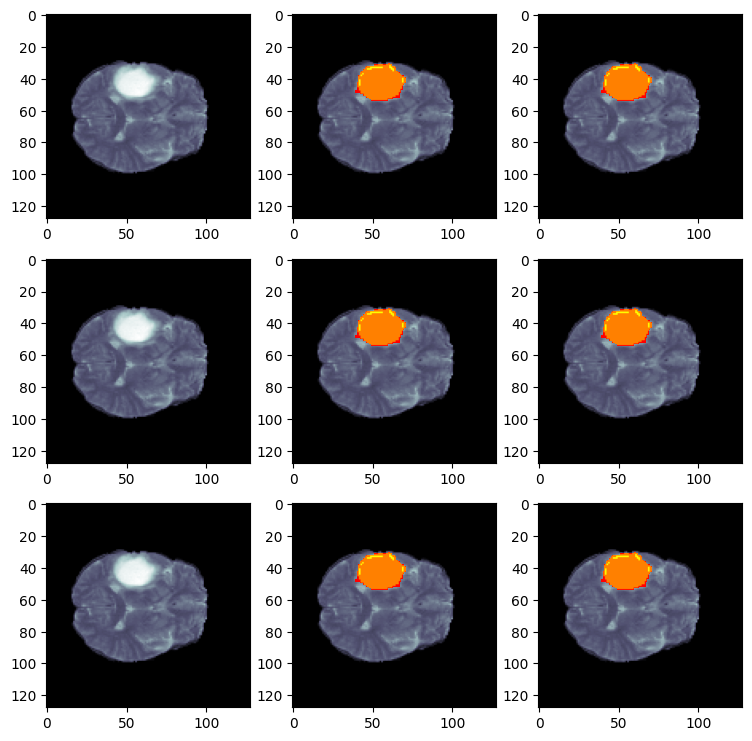

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
  for j in range(3):
    slice, mask = train_dataset[130]
    mask_ = np.ma.masked_where(mask == 0, mask)
    axis[i][j].imshow(slice[3], cmap="bone")
    if j == 0:
      continue
    axis[i][j].imshow(mask_[0], cmap="autumn")

In [ ]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [ ]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, pred, mask):
    pred = torch.flatten(pred)
    mask = torch.flatten(mask)

    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() + 1e-8

    return 1 - ((2 * intersection) / union)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),  # Corrected line
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.center = self.conv_block(512, 1024)

        self.decoder4 = self.conv_block(1024 + 512, 512)
        self.decoder3 = self.conv_block(512 + 256, 256)
        self.decoder2 = self.conv_block(256 + 128, 128)
        self.decoder1 = self.conv_block(128 + 64, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)

        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.se1(self.encoder1(x))
        e2 = self.se2(self.encoder2(self.pool(e1)))
        e3 = self.se3(self.encoder3(self.pool(e2)))
        e4 = self.se4(self.encoder4(self.pool(e3)))

        center = self.center(self.pool(e4))

        d4 = self.decoder4(torch.cat([F.interpolate(center, scale_factor=2, mode='bilinear', align_corners=True), e4], 1))
        d3 = self.decoder3(torch.cat([F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True), e3], 1))
        d2 = self.decoder2(torch.cat([F.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2], 1))
        d1 = self.decoder1(torch.cat([F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1], 1))

        return self.final(d1)


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [ ]:
img = torch.randn(1, 4, 128, 128).to(device)
model = UNet(4, 4).to(device)
out = model(img)
print(out.shape)

torch.Size([1, 4, 128, 128])


In [ ]:
model = UNet(4, 4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
# device = 'cuda'
# import torch, gc
# import os
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# from numba import cuda

# cuda.select_device(0) # choosing second GPU

# cuda.close()

In [ ]:
for epoch in range(20):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, masks in tqdm(train_loader):
        inputs, masks = inputs.float().to(device), masks.long().squeeze(1).to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        # outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs.squeeze(1), masks)  # Adjust the output shape if necessary
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    scheduler.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, masks in val_loader:
            inputs, masks = inputs.float().to(device), masks.long().squeeze(1).to(device)
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs).to(device)
            loss = criterion(outputs.squeeze(1), masks)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')


100%|██████████| 746/746 [11:07<00:00,  1.12it/s]


Epoch 1, Train Loss: 0.2768, Val Loss: 0.0832


100%|██████████| 746/746 [11:10<00:00,  1.11it/s]


Epoch 2, Train Loss: 0.0464, Val Loss: 0.0295


100%|██████████| 746/746 [11:10<00:00,  1.11it/s]


Epoch 3, Train Loss: 0.0197, Val Loss: 0.0177


100%|██████████| 746/746 [11:10<00:00,  1.11it/s]


Epoch 4, Train Loss: 0.0126, Val Loss: 0.0152


100%|██████████| 746/746 [11:10<00:00,  1.11it/s]


Epoch 5, Train Loss: 0.0101, Val Loss: 0.0132


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 6, Train Loss: 0.0084, Val Loss: 0.0125


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 7, Train Loss: 0.0070, Val Loss: 0.0120


100%|██████████| 746/746 [11:12<00:00,  1.11it/s]


Epoch 8, Train Loss: 0.0064, Val Loss: 0.0118


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 9, Train Loss: 0.0059, Val Loss: 0.0118


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 10, Train Loss: 0.0053, Val Loss: 0.0121


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 11, Train Loss: 0.0050, Val Loss: 0.0116


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 12, Train Loss: 0.0048, Val Loss: 0.0118


100%|██████████| 746/746 [11:11<00:00,  1.11it/s]


Epoch 13, Train Loss: 0.0044, Val Loss: 0.0123


 15%|█▍        | 109/746 [01:39<09:40,  1.10it/s]


KeyboardInterrupt: 

In [ ]:
model_save_path = 'brain_tumor_segmentation_UNet3plus.pth'
torch.save(model.state_dict(), model_save_path)